<a href="https://colab.research.google.com/github/mk0653/untitled/blob/master/clrp_pytorch_Deberta_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook uses the model created in pretrain any model notebook.

1. Pretrain Roberta Model: https://www.kaggle.com/maunish/clrp-pytorch-roberta-pretrain
2. Finetune Roberta Model: this notebook, <br/>
   Finetune Roberta Model TPU: https://www.kaggle.com/maunish/clrp-pytorch-roberta-finetune-tpu
3. Inference Notebook: https://www.kaggle.com/maunish/clrp-pytorch-roberta-inference
4. Roberta + SVM: https://www.kaggle.com/maunish/clrp-roberta-svm

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!pip install transformers

In [10]:
!pip install accelerate

In [11]:
pip install colorama

In [12]:
import os
import gc
import sys
import math
import time
import tqdm
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from accelerate import Accelerator
from transformers import (AutoModel,AutoConfig,
                          AutoTokenizer,get_cosine_schedule_with_warmup)

from colorama import Fore, Back, Style
r_ = Fore.RED
b_ = Fore.BLUE
c_ = Fore.CYAN
g_ = Fore.GREEN
y_ = Fore.YELLOW
m_ = Fore.MAGENTA
sr_ = Style.RESET_ALL

In [18]:
train_data = pd.read_csv('/content/drive/MyDrive/[NLP]医療論文仕分けコンペ/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/[NLP]医療論文仕分けコンペ/test.csv')
sample = pd.read_csv('/content/drive/MyDrive/[NLP]医療論文仕分けコンペ/sample_submit.csv')


train_data['abstract'] = train_data['title'].str.cat(train_data['abstract'], na_rep='')

num_bins = int(np.floor(1 + np.log2(len(train_data))))
train_data.loc[:,'bins'] = pd.cut(train_data['judgement'],bins=num_bins,labels=False)

bins = train_data.bins.to_numpy()
target = train_data.judgement.to_numpy()

def rmse_score(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

In [19]:
config = {
    'lr': 2e-5,
    'wd':0.01,
    'batch_size':8,
    'valid_step':10,
    'max_len':256,
    'epochs':3,
    'nfolds':5,
    'seed':42,
    'model_path':'/content/drive/MyDrive/roberta_large',
}

for i in range(config['nfolds']):
    os.makedirs(f'/content/drive/MyDrive/model{i}',exist_ok=True)

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=config['seed'])

train_data['Fold'] = -1
kfold = StratifiedKFold(n_splits=config['nfolds'],shuffle=True,random_state=config['seed'])
for k , (train_idx,valid_idx) in enumerate(kfold.split(X=train_data,y=bins)):
    train_data.loc[valid_idx,'Fold'] = k

In [20]:
train_data.head()

,id,title,abstract,judgement,bins,Fold
0,0,One-year age changes in MRI brain volumes in o...,One-year age changes in MRI brain volumes in o...,0,0,1
1,1,Supportive CSF biomarker evidence to enhance t...,Supportive CSF biomarker evidence to enhance t...,0,0,1
2,2,Occurrence of basal ganglia germ cell tumors w...,Occurrence of basal ganglia germ cell tumors w...,0,0,1
3,3,New developments in diagnosis and therapy of C...,New developments in diagnosis and therapy of C...,0,0,2
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,Prolonged shedding of SARS-CoV-2 in an elderly...,0,0,1


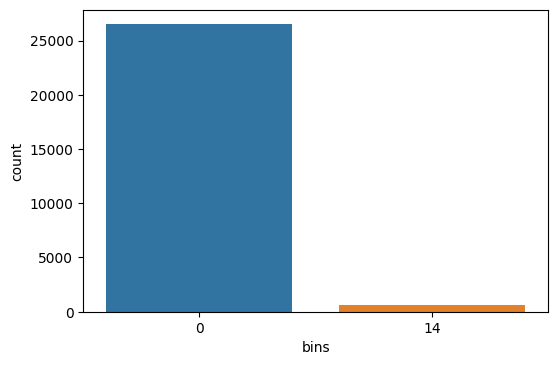

In [21]:
plt.figure(dpi=100)
sns.countplot(train_data.bins);

In [24]:
class CLRPDataset(Dataset):
    def __init__(self,df,tokenizer,max_len=128):
        self.excerpt = df['abstract'].to_numpy()
        self.targets = df['judgement'].to_numpy()
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self,idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        
        target = torch.tensor(self.targets[idx],dtype=torch.float) 
        return encode, target
    
    def __len__(self):
        return len(self.excerpt)

In [25]:
class AttentionHead(nn.Module):
    def __init__(self, in_features, hidden_dim):
        super().__init__()
        self.in_features = in_features
        self.middle_features = hidden_dim
        self.W = nn.Linear(in_features, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        self.out_features = hidden_dim

    def forward(self, features):
        att = torch.tanh(self.W(features))
        score = self.V(att)
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector

In [26]:
class Model(nn.Module):
    def __init__(self,path):
        super(Model,self).__init__()
        self.albert = AutoModel.from_pretrained(path)  
        self.config = AutoConfig.from_pretrained(path)
        self.head = AttentionHead(self.config.hidden_size,self.config.hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(self.config.hidden_size,1)

    def forward(self,**xb):
        x = self.albert(**xb)[0]
        x = self.head(x)
        x = self.dropout(x)
        x = self.linear(x)
        return x

In [27]:
def run(fold,verbose=True):
    
    def loss_fn(outputs,targets):
        outputs = outputs.view(-1)
        targets = targets.view(-1)
        return torch.sqrt(nn.MSELoss()(outputs,targets))
    
    def train_and_evaluate_loop(train_loader,valid_loader,model,loss_fn,optimizer,epoch,fold,best_loss,valid_step=10,lr_scheduler=None):
        train_loss = 0
        for i, (inputs1,targets1) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            inputs1 = {key:val.reshape(val.shape[0],-1) for key,val in inputs1.items()}
            outputs1 = model(**inputs1)
            loss1 = loss_fn(outputs1,targets1)
            loss1.backward()
            optimizer.step()
            
            train_loss += loss1.item()
            
            if lr_scheduler:
                lr_scheduler.step()
            
            #evaluating for every valid_step
            if (i % valid_step == 0) or ((i + 1) == len(train_loader)):
                model.eval()
                valid_loss = 0
                with torch.no_grad():
                    for j, (inputs2,targets2) in enumerate(valid_loader):
                        inputs2 = {key:val.reshape(val.shape[0],-1) for key,val in inputs2.items()}
                        outputs2 = model(**inputs2)
                        loss2 = loss_fn(outputs2,targets2)
                        valid_loss += loss2.item()
                     
                    valid_loss /= len(valid_loader)
                    if valid_loss <= best_loss:
                        if verbose:
                            print(f"epoch:{epoch} | Train Loss:{train_loss/(i+1)} | Validation loss:{valid_loss}")
                            print(f"{g_}Validation loss Decreased from {best_loss} to {valid_loss}{sr_}")

                        best_loss = valid_loss
                        torch.save(model.state_dict(),f'/content/drive/MyDrive/model{fold}/model{fold}.bin')
                        tokenizer.save_pretrained(f'/content/drive/MyDrive/model{fold}')
                        
        return best_loss
    
    accelerator = Accelerator()
    print(f"{accelerator.device} is used")
    
    x_train,x_valid = train_data.query(f"Fold != {fold}"),train_data.query(f"Fold == {fold}")
    
    tokenizer = AutoTokenizer.from_pretrained(config['model_path'])
    model = Model(config['model_path'])

    train_ds = CLRPDataset(x_train,tokenizer,config['max_len'])
    train_dl = DataLoader(train_ds,
                        batch_size = config["batch_size"],
                        shuffle=True,
                        num_workers = 4,
                        pin_memory=True,
                        drop_last=False)

    valid_ds = CLRPDataset(x_valid,tokenizer,config['max_len'])
    valid_dl = DataLoader(valid_ds,
                        batch_size = config["batch_size"],
                        shuffle=False,
                        num_workers = 4,
                        pin_memory=True,
                        drop_last=False)

    optimizer = optim.AdamW(model.parameters(),lr=config['lr'],weight_decay=config['wd'])
    lr_scheduler = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps= 10 * len(train_dl))

    model,train_dl,valid_dl,optimizer,lr_scheduler = accelerator.prepare(model,train_dl,valid_dl,optimizer,lr_scheduler)

    print(f"Fold: {fold}")
    best_loss = 9999
    for epoch in range(config["epochs"]):
        print(f"Epoch Started:{epoch}")
        best_loss = train_and_evaluate_loop(train_dl,valid_dl,model,loss_fn,
                                            optimizer,epoch,fold,best_loss,
                                            valid_step=config['valid_step'],lr_scheduler=lr_scheduler)

In [ ]:
gc.collect()
for f in range(config['nfolds']):
    run(f)

cuda is used


Some weights of the model checkpoint at /content/drive/MyDrive/roberta_large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/roberta_large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions

Fold: 0
Epoch Started:0
epoch:0 | Train Loss:0.11446037888526917 | Validation loss:0.4551010862190348
Validation loss Decreased from 9999 to 0.4551010862190348
epoch:0 | Train Loss:0.1722800691019405 | Validation loss:0.11617878841480381
Validation loss Decreased from 0.4551010862190348 to 0.11617878841480381
epoch:0 | Train Loss:0.1469438017479011 | Validation loss:0.07576050343052299
Validation loss Decreased from 0.11617878841480381 to 0.07576050343052299
epoch:0 | Train Loss:0.1277356881901254 | Validation loss:0.07359179773948132
Validation loss Decreased from 0.07576050343052299 to 0.07359179773948132
epoch:0 | Train Loss:0.12605609446887348 | Validation loss:0.07054508699170027
Validation loss Decreased from 0.07359179773948132 to 0.07054508699170027
epoch:0 | Train Loss:0.11786849622487157 | Validation loss:0.0688501215949298
Validation loss Decreased from 0.07054508699170027 to 0.0688501215949298
epoch:0 | Train Loss:0.11433007628261713 | Validation loss:0.06768485967794075
Va

Validation loss Decreased from 0.5992907591991954 to 0.5668752615650495

epoch:0 | Train Loss:0.723939770544079 | Validation loss:0.5399345523781247

Validation loss Decreased from 0.5668752615650495 to 0.5399345523781247

epoch:0 | Train Loss:0.6412996309847872 | Validation loss:0.5067524686455727

Validation loss Decreased from 0.5399345523781247 to 0.5067524686455727

Epoch Started:1

epoch:1 | Train Loss:0.45839802282197134 | Validation loss:0.5031425489319695

Validation loss Decreased from 0.5067524686455727 to 0.5031425489319695

Epoch Started:2

cuda is used
Some weights of the model checkpoint at /content/drive/MyDrive/clrp_deberta_large were not used when initializing DebertaModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Fold: 2
Epoch Started:0
epoch:0 | Train Loss:1.5339882373809814 | Validation loss:1.1018134846653738
Validation loss Decreased from 9999 to 1.1018134846653738
epoch:0 | Train Loss:1.2023406787352129 | Validation loss:0.9195654329279779
Validation loss Decreased from 1.1018134846653738 to 0.9195654329279779
epoch:0 | Train Loss:1.0459352277574085 | Validation loss:0.770928899272227
Validation loss Decreased from 0.9195654329279779 to 0.770928899272227
epoch:0 | Train Loss:0.9199109639852278 | Validation loss:0.7171326644823585
Validation loss Decreased from 0.770928899272227 to 0.7171326644823585
epoch:0 | Train Loss:0.8771063202038044 | Validation loss:0.6371641475969637
Validation loss Decreased from 0.7171326644823585 to 0.6371641475969637
epoch:0 | Train Loss:0.8451492125299614 | Validation loss:0.6037529071032162
Validation loss Decreased from 0.6371641475969637 to 0.6037529071032162
epoch:0 | Train Loss:0.8174791937624967 | Validation loss:0.5918939384356351
Validation loss Decreased from 0.6037529071032162 to 0.5918939384356351
epoch:0 | Train Loss:0.7876839210371395 | Validation loss:0.5655518406083886
Validation loss Decreased from 0.5918939384356351 to 0.5655518406083886
epoch:0 | Train Loss:0.7167889363921008 | Validation loss:0.5522066115493506
Validation loss Decreased from 0.5655518406083886 to 0.5522066115493506
epoch:0 | Train Loss:0.7086261122649006 | Validation loss:0.5382329699858813
Validation loss Decreased from 0.5522066115493506 to 0.5382329699858813
epoch:0 | Train Loss:0.70569380937522 | Validation loss:0.5343834798730595
Validation loss Decreased from 0.5382329699858813 to 0.5343834798730595
epoch:0 | Train Loss:0.6954040784691888 | Validation loss:0.5265876306089717
Validation loss Decreased from 0.5343834798730595 to 0.5265876306089717
epoch:0 | Train Loss:0.6929470235886781 | Validation loss:0.5165272117920325
Validation loss Decreased from 0.5265876306089717 to 0.5165272117920325
epoch:0 | Train Loss:0.6757399174691259 | Validation loss:0.5093536971950196
Validation loss Decreased from 0.5165272117920325 to 0.5093536971950196
epoch:0 | Train Loss:0.6713985153270611 | Validation loss:0.5065483653419455
Validation loss Decreased from 0.5093536971950196 to 0.5065483653419455
Epoch Started:1
epoch:1 | Train Loss:0.4869140400127931 | Validation loss:0.5056863585093492
Validation loss Decreased from 0.5065483653419455 to 0.5056863585093492
epoch:1 | Train Loss:0.4733624590969667 | Validation loss:0.49288781742814564
Validation loss Decreased from 0.5056863585093492 to 0.49288781742814564
epoch:1 | Train Loss:0.4644895609456967 | Validation loss:0.49227010080931893
Validation loss Decreased from 0.49288781742814564 to 0.49227010080931893
epoch:1 | Train Loss:0.4644904254506601 | Validation loss:0.4883344232196539
Validation loss Decreased from 0.49227010080931893 to 0.4883344232196539
epoch:1 | Train Loss:0.4685445793425034 | Validation loss:0.48749182273594427
Validation loss Decreased from 0.4883344232196539 to 0.48749182273594427
Epoch Started:2
epoch:2 | Train Loss:0.3615002399038153 | Validation loss:0.47860990275799387
Validation loss Decreased from 0.48749182273594427 to 0.47860990275799387
cuda is used
Some weights of the model checkpoint at /content/drive/MyDrive/clrp_deberta_large were not used when initializing DebertaModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Fold: 3
Epoch Started:0
epoch:0 | Train Loss:1.5396836996078491 | Validation loss:1.045226339303272
Validation loss Decreased from 9999 to 1.045226339303272
epoch:0 | Train Loss:1.013715611262755 | Validation loss:0.9690218455564807
Validation loss Decreased from 1.045226339303272 to 0.9690218455564807
epoch:0 | Train Loss:1.0788483179750896 | Validation loss:0.6213600420406167
Validation loss Decreased from 0.9690218455564807 to 0.6213600420406167
epoch:0 | Train Loss:0.9501345003804853 | Validation loss:0.5872292184913662
Validation loss Decreased from 0.6213600420406167 to 0.5872292184913662
epoch:0 | Train Loss:0.7587827404833022 | Validation loss:0.5775447883446452
Validation loss Decreased from 0.5872292184913662 to 0.5775447883446452
epoch:0 | Train Loss:0.7545652775794056 | Validation loss:0.5408451609628301
Validation loss Decreased from 0.5775447883446452 to 0.5408451609628301
epoch:0 | Train Loss:0.7020426447556906 | Validation loss:0.5345618752106814
Validation loss Decreased from 0.5408451609628301 to 0.5345618752106814
epoch:0 | Train Loss:0.6986307737913298 | Validation loss:0.5138172133707665
Validation loss Decreased from 0.5345618752106814 to 0.5138172133707665
epoch:0 | Train Loss:0.6693749189796045 | Validation loss:0.4998545233212726
Validation loss Decreased from 0.5138172133707665 to 0.4998545233212726
epoch:0 | Train Loss:0.6634011703085446 | Validation loss:0.49178518879581506
Validation loss Decreased from 0.4998545233212726 to 0.49178518879581506
epoch:0 | Train Loss:0.6582495454164404 | Validation loss:0.4682268832980747
Validation loss Decreased from 0.49178518879581506 to 0.4682268832980747
Epoch Started:1
epoch:1 | Train Loss:0.4571445965074085 | Validation loss:0.46480296552181244
Validation loss Decreased from 0.4682268832980747 to 0.46480296552181244
epoch:1 | Train Loss:0.44593468321454793 | Validation loss:0.45221721417677235
Validation loss Decreased from 0.46480296552181244 to 0.45221721417677235
Epoch Started:2
cuda is used
Some weights of the model checkpoint at /content/drive/MyDrive/clrp_deberta_large were not used when initializing DebertaModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Fold: 4
Epoch Started:0
epoch:0 | Train Loss:1.3526334762573242 | Validation loss:1.043923421434953
Validation loss Decreased from 9999 to 1.043923421434953
epoch:0 | Train Loss:1.0277932340448552 | Validation loss:0.8878293627164733
Validation loss Decreased from 1.043923421434953 to 0.8878293627164733
epoch:0 | Train Loss:0.9280650743416378 | Validation loss:0.6403588732363472
Validation loss Decreased from 0.8878293627164733 to 0.6403588732363472
epoch:0 | Train Loss:0.8112837745517981 | Validation loss:0.5826853669025529
Validation loss Decreased from 0.6403588732363472 to 0.5826853669025529
epoch:0 | Train Loss:0.7802146018287281 | Validation loss:0.5356398628053951
Validation loss Decreased from 0.5826853669025529 to 0.5356398628053951
epoch:0 | Train Loss:0.7361272820307099 | Validation loss:0.5245677983047257
Validation loss Decreased from 0.5356398628053951 to 0.5245677983047257
epoch:0 | Train Loss:0.690459638299695 | Validation loss:0.521551561397566
Validation loss Decreased from 0.5245677983047257 to 0.521551561397566
epoch:0 | Train Loss:0.6784999489877083 | Validation loss:0.508647812268054
Validation loss Decreased from 0.521551561397566 to 0.508647812268054
epoch:0 | Train Loss:0.646831636120673 | Validation loss:0.49024367736468855
Validation loss Decreased from 0.508647812268054 to 0.49024367736468855
epoch:0 | Train Loss:0.636865869357273 | Validation loss:0.4869585412383919
Validation loss Decreased from 0.49024367736468855 to 0.4869585412383919
Epoch Started:1
epoch:1 | Train Loss:0.4233155191921797 | Validation loss:0.4761068085864396
Validation loss Decreased from 0.4869585412383919 to 0.4761068085864396
epoch:1 | Train Loss:0.44014547505351 | Validation loss:0.4732538685727287
Validation loss Decreased from 0.4761068085864396 to 0.4732538685727287
Epoch Started:2
epoch:2 | Train Loss:0.3334113076723964 | Validation loss:0.47262863248166903
Validation loss Decreased from 0.4732538685727287 to 0.47262863248166903
epoch:2 | Train Loss:0.33792266479704486 | Validation loss:0.46382192590496907
Validation loss Decreased from 0.47262863248166903 to 0.46382192590496907

cuda is used
Some weights of the model checkpoint at /content/drive/MyDrive/clrp_albert_xlarge_v2 were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at /content/drive/MyDrive/clrp_albert_xlarge_v2 and are newly initialized: ['albert.pooler.weight', 'albert.pooler.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fold: 0
Epoch Started:0
epoch:0 | Train Loss:1.2132810354232788 | Validation loss:1.0510766250146946
Validation loss Decreased from 9999 to 1.0510766250146946
epoch:0 | Train Loss:1.016547972505743 | Validation loss:0.8792177195280371
Validation loss Decreased from 1.0510766250146946 to 0.8792177195280371
epoch:0 | Train Loss:0.8735912754422143 | Validation loss:0.7240229022334999
Validation loss Decreased from 0.8792177195280371 to 0.7240229022334999
epoch:0 | Train Loss:0.8084834728573189 | Validation loss:0.6978504107871526
Validation loss Decreased from 0.7240229022334999 to 0.6978504107871526
epoch:0 | Train Loss:0.7933886754260936 | Validation loss:0.6729309919854285
Validation loss Decreased from 0.6978504107871526 to 0.6729309919854285
epoch:0 | Train Loss:0.7605782218359329 | Validation loss:0.6306273710559791
Validation loss Decreased from 0.6729309919854285 to 0.6306273710559791
epoch:0 | Train Loss:0.7405176997774898 | Validation loss:0.6232521554953615
Validation loss Decreased from 0.6306273710559791 to 0.6232521554953615
epoch:0 | Train Loss:0.7188766214019018 | Validation loss:0.5952457206349977
Validation loss Decreased from 0.6232521554953615 to 0.5952457206349977
epoch:0 | Train Loss:0.6982866429274355 | Validation loss:0.564664643415263
Validation loss Decreased from 0.5952457206349977 to 0.564664643415263
epoch:0 | Train Loss:0.6819179887637431 | Validation loss:0.5485147036297221
Validation loss Decreased from 0.564664643415263 to 0.5485147036297221
Epoch Started:1
epoch:1 | Train Loss:0.5511268665713649 | Validation loss:0.5440304997101636
Validation loss Decreased from 0.5485147036297221 to 0.5440304997101636
epoch:1 | Train Loss:0.5391701474422361 | Validation loss:0.5372833009337036
Validation loss Decreased from 0.5440304997101636 to 0.5372833009337036
epoch:1 | Train Loss:0.5195226620455258 | Validation loss:0.535369486875937
Validation loss Decreased from 0.5372833009337036 to 0.535369486875937
epoch:1 | Train Loss:0.5109942430331383 | Validation loss:0.5334647921189456
Validation loss Decreased from 0.535369486875937 to 0.5334647921189456
epoch:1 | Train Loss:0.5261193698977832 | Validation loss:0.5274029021531763
Validation loss Decreased from 0.5334647921189456 to 0.5274029021531763
epoch:1 | Train Loss:0.5193598245065737 | Validation loss:0.5151790174799906
Validation loss Decreased from 0.5274029021531763 to 0.5151790174799906
Epoch Started:2
epoch:2 | Train Loss:0.3865937252763573 | Validation loss:0.507169804102938
Validation loss Decreased from 0.5151790174799906 to 0.507169804102938
epoch:2 | Train Loss:0.39276605328959874 | Validation loss:0.5064182791491629
Validation loss Decreased from 0.507169804102938 to 0.5064182791491629
cuda is used
Some weights of the model checkpoint at /content/drive/MyDrive/clrp_albert_xlarge_v2 were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at /content/drive/MyDrive/clrp_albert_xlarge_v2 and are newly initialized: ['albert.pooler.weight', 'albert.pooler.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fold: 1
Epoch Started:0
epoch:0 | Train Loss:0.9406171441078186 | Validation loss:1.0655220104774958
Validation loss Decreased from 9999 to 1.0655220104774958
epoch:0 | Train Loss:1.099583457816731 | Validation loss:1.0174494528434646
Validation loss Decreased from 1.0655220104774958 to 1.0174494528434646
epoch:0 | Train Loss:1.0244464647202265 | Validation loss:0.8720986041384684
Validation loss Decreased from 1.0174494528434646 to 0.8720986041384684
epoch:0 | Train Loss:0.9795878068093331 | Validation loss:0.8019071087031298
Validation loss Decreased from 0.8720986041384684 to 0.8019071087031298
epoch:0 | Train Loss:0.9386255057846628 | Validation loss:0.6958212386554395
Validation loss Decreased from 0.8019071087031298 to 0.6958212386554395
epoch:0 | Train Loss:0.8437089157886193 | Validation loss:0.677840853660879
Validation loss Decreased from 0.6958212386554395 to 0.677840853660879
epoch:0 | Train Loss:0.8147809526450197 | Validation loss:0.6347588829591241
Validation loss Decreased from 0.677840853660879 to 0.6347588829591241
epoch:0 | Train Loss:0.7738258462030809 | Validation loss:0.6298477322282926
Validation loss Decreased from 0.6347588829591241 to 0.6298477322282926
epoch:0 | Train Loss:0.7204443794607327 | Validation loss:0.6283668237672725
Validation loss Decreased from 0.6298477322282926 to 0.6283668237672725
epoch:0 | Train Loss:0.6943752208302693 | Validation loss:0.6162040334352306
Validation loss Decreased from 0.6283668237672725 to 0.6162040334352306
epoch:0 | Train Loss:0.6800458961887057 | Validation loss:0.5960067915664592
Validation loss Decreased from 0.6162040334352306 to 0.5960067915664592
epoch:0 | Train Loss:0.6783558939626108 | Validation loss:0.5847520102077807
Validation loss Decreased from 0.5960067915664592 to 0.5847520102077807
epoch:0 | Train Loss:0.6707805169134562 | Validation loss:0.5757098531639072
Validation loss Decreased from 0.5847520102077807 to 0.5757098531639072
Epoch Started:1
epoch:1 | Train Loss:0.5722205062066356 | Validation loss:0.5692170083942548
Validation loss Decreased from 0.5757098531639072 to 0.5692170083942548
epoch:1 | Train Loss:0.5617544236706524 | Validation loss:0.5551356335341091
Validation loss Decreased from 0.5692170083942548 to 0.5551356335341091
epoch:1 | Train Loss:0.559095552738975 | Validation loss:0.5463487835417331
Validation loss Decreased from 0.5551356335341091 to 0.5463487835417331
epoch:1 | Train Loss:0.5516854665469174 | Validation loss:0.5375950401517707
Validation loss Decreased from 0.5463487835417331 to 0.5375950401517707
Epoch Started:2
epoch:2 | Train Loss:0.44385703743957894 | Validation loss:0.5236077394703744
Validation loss Decreased from 0.5375950401517707 to 0.5236077394703744
epoch:2 | Train Loss:0.4445870465222206 | Validation loss:0.5173325643573009
Validation loss Decreased from 0.5236077394703744 to 0.5173325643573009
cuda is used
Some weights of the model checkpoint at /content/drive/MyDrive/clrp_albert_xlarge_v2 were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at /content/drive/MyDrive/clrp_albert_xlarge_v2 and are newly initialized: ['albert.pooler.weight', 'albert.pooler.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fold: 2
Epoch Started:0
epoch:0 | Train Loss:1.3689159154891968 | Validation loss:1.0215006911418807
Validation loss Decreased from 9999 to 1.0215006911418807
epoch:0 | Train Loss:1.0469979643821716 | Validation loss:0.8648192093405925
Validation loss Decreased from 1.0215006911418807 to 0.8648192093405925
epoch:0 | Train Loss:0.9076351651123592 | Validation loss:0.7514897593310181
Validation loss Decreased from 0.8648192093405925 to 0.7514897593310181
epoch:0 | Train Loss:0.8965943205741144 | Validation loss:0.7095640301704407
Validation loss Decreased from 0.7514897593310181 to 0.7095640301704407
epoch:0 | Train Loss:0.855297854760798 | Validation loss:0.700924825290559
Validation loss Decreased from 0.7095640301704407 to 0.700924825290559
epoch:0 | Train Loss:0.8030312974921993 | Validation loss:0.674967822054742
Validation loss Decreased from 0.700924825290559 to 0.674967822054742
epoch:0 | Train Loss:0.7670293715265062 | Validation loss:0.6149005745078476
Validation loss Decreased from 0.674967822054742 to 0.6149005745078476
epoch:0 | Train Loss:0.7513317436307341 | Validation loss:0.5702131581558308
Validation loss Decreased from 0.6149005745078476 to 0.5702131581558308
epoch:0 | Train Loss:0.6916770543760926 | Validation loss:0.5456669078746312
Validation loss Decreased from 0.5702131581558308 to 0.5456669078746312
epoch:0 | Train Loss:0.6659314417090091 | Validation loss:0.541403280387462
Validation loss Decreased from 0.5456669078746312 to 0.541403280387462
epoch:0 | Train Loss:0.6574033263014324 | Validation loss:0.5367201258179167
Validation loss Decreased from 0.541403280387462 to 0.5367201258179167
epoch:0 | Train Loss:0.6572100062985226 | Validation loss:0.5314437843544383
Validation loss Decreased from 0.5367201258179167 to 0.5314437843544383
epoch:0 | Train Loss:0.6519070534737079 | Validation loss:0.5173060367224922
Validation loss Decreased from 0.5314437843544383 to 0.5173060367224922
Epoch Started:1
epoch:1 | Train Loss:0.4918090445167236 | Validation loss:0.5141464530582159
Validation loss Decreased from 0.5173060367224922 to 0.5141464530582159
Epoch Started:2
epoch:2 | Train Loss:0.3975763086761747 | Validation loss:0.5097126335325376
Validation loss Decreased from 0.5141464530582159 to 0.5097126335325376
epoch:2 | Train Loss:0.38278972477682177 | Validation loss:0.5086808171070797
Validation loss Decreased from 0.5097126335325376 to 0.5086808171070797
epoch:2 | Train Loss:0.38284187127904196 | Validation loss:0.5018977440998588
Validation loss Decreased from 0.5086808171070797 to 0.5018977440998588
epoch:2 | Train Loss:0.3953756848476591 | Validation loss:0.49025066050005633
Validation loss Decreased from 0.5018977440998588 to 0.49025066050005633
epoch:2 | Train Loss:0.39388340526101995 | Validation loss:0.4869628647263621
Validation loss Decreased from 0.49025066050005633 to 0.4869628647263621
cuda is used
Some weights of the model checkpoint at /content/drive/MyDrive/clrp_albert_xlarge_v2 were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at /content/drive/MyDrive/clrp_albert_xlarge_v2 and are newly initialized: ['albert.pooler.weight', 'albert.pooler.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fold: 3
Epoch Started:0
epoch:0 | Train Loss:0.8091953992843628 | Validation loss:1.0435537334898828
Validation loss Decreased from 9999 to 1.0435537334898828
epoch:0 | Train Loss:0.9331630414182489 | Validation loss:0.9483419711321173
Validation loss Decreased from 1.0435537334898828 to 0.9483419711321173
epoch:0 | Train Loss:0.8234872817993164 | Validation loss:0.8825650307494151
Validation loss Decreased from 0.9483419711321173 to 0.8825650307494151
epoch:0 | Train Loss:0.873782463612095 | Validation loss:0.7621127123564062
Validation loss Decreased from 0.8825650307494151 to 0.7621127123564062
epoch:0 | Train Loss:0.8344071507453918 | Validation loss:0.6640060581791569
Validation loss Decreased from 0.7621127123564062 to 0.6640060581791569
epoch:0 | Train Loss:0.762415522923235 | Validation loss:0.6508878633170061
Validation loss Decreased from 0.6640060581791569 to 0.6508878633170061
epoch:0 | Train Loss:0.7567126780328616 | Validation loss:0.6402479196098488
Validation loss Decreased from 0.6508878633170061 to 0.6402479196098488
epoch:0 | Train Loss:0.7435390137054108 | Validation loss:0.5700231643629746
Validation loss Decreased from 0.6402479196098488 to 0.5700231643629746
epoch:0 | Train Loss:0.7396178874048857 | Validation loss:0.5699580292886411
Validation loss Decreased from 0.5700231643629746 to 0.5699580292886411
epoch:0 | Train Loss:0.7222400827348725 | Validation loss:0.5650586548825385
Validation loss Decreased from 0.5699580292886411 to 0.5650586548825385
epoch:0 | Train Loss:0.7200412233822219 | Validation loss:0.5552213498404328
Validation loss Decreased from 0.5650586548825385 to 0.5552213498404328
epoch:0 | Train Loss:0.6954209055119788 | Validation loss:0.55254034907885
Validation loss Decreased from 0.5552213498404328 to 0.55254034907885
epoch:0 | Train Loss:0.6856138162420824 | Validation loss:0.5413784623985559
Validation loss Decreased from 0.55254034907885 to 0.5413784623985559
epoch:0 | Train Loss:0.6795114541982675 | Validation loss:0.5410246444000325
Validation loss Decreased from 0.5413784623985559 to 0.5410246444000325
epoch:0 | Train Loss:0.6766565798229202 | Validation loss:0.5397399109853825
Validation loss Decreased from 0.5410246444000325 to 0.5397399109853825
Epoch Started:1
epoch:1 | Train Loss:0.5374819993133276 | Validation loss:0.5248952847971043
Validation loss Decreased from 0.5397399109853825 to 0.5248952847971043
epoch:1 | Train Loss:0.5543654570098739 | Validation loss:0.5248486659896205
Validation loss Decreased from 0.5248952847971043 to 0.5248486659896205
epoch:1 | Train Loss:0.5406567460521128 | Validation loss:0.5238935798406601
Validation loss Decreased from 0.5248486659896205 to 0.5238935798406601
epoch:1 | Train Loss:0.5391451462938337 | Validation loss:0.513818223081844
Validation loss Decreased from 0.5238935798406601 to 0.513818223081844
Epoch Started:2
epoch:2 | Train Loss:0.4289773560968446 | Validation loss:0.5052631640098464
Validation loss Decreased from 0.513818223081844 to 0.5052631640098464
epoch:2 | Train Loss:0.43202752601509253 | Validation loss:0.5009493714487049
Validation loss Decreased from 0.5052631640098464 to 0.5009493714487049
epoch:2 | Train Loss:0.45103617727316614 | Validation loss:0.4967938892438378
Validation loss Decreased from 0.5009493714487049 to 0.4967938892438378
cuda is used
Some weights of the model checkpoint at /content/drive/MyDrive/clrp_albert_xlarge_v2 were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertModel were not initialized from the model checkpoint at /content/drive/MyDrive/clrp_albert_xlarge_v2 and are newly initialized: ['albert.pooler.weight', 'albert.pooler.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fold: 4
Epoch Started:0
epoch:0 | Train Loss:1.0248457193374634 | Validation loss:1.090473430257448
Validation loss Decreased from 9999 to 1.090473430257448
epoch:0 | Train Loss:0.9050093537027185 | Validation loss:0.9147115572237633
Validation loss Decreased from 1.090473430257448 to 0.9147115572237633
epoch:0 | Train Loss:0.921067122902189 | Validation loss:0.8396302835202553
Validation loss Decreased from 0.9147115572237633 to 0.8396302835202553
epoch:0 | Train Loss:0.8967714915352483 | Validation loss:0.7080488041253157
Validation loss Decreased from 0.8396302835202553 to 0.7080488041253157
epoch:0 | Train Loss:0.8847992325701365 | Validation loss:0.6811294328998512
Validation loss Decreased from 0.7080488041253157 to 0.6811294328998512
epoch:0 | Train Loss:0.8399373669116224 | Validation loss:0.6705871963165175
Validation loss Decreased from 0.6811294328998512 to 0.6705871963165175
epoch:0 | Train Loss:0.8126827491001344 | Validation loss:0.6082563746563145
Validation loss Decreased from 0.6705871963165175 to 0.6082563746563145
epoch:0 | Train Loss:0.7668023714334657 | Validation loss:0.5641633368713755
Validation loss Decreased from 0.6082563746563145 to 0.5641633368713755
epoch:0 | Train Loss:0.7356543803451866 | Validation loss:0.5513910155900767
Validation loss Decreased from 0.5641633368713755 to 0.5513910155900767
epoch:0 | Train Loss:0.7241591112306941 | Validation loss:0.5463290766511165
Validation loss Decreased from 0.5513910155900767 to 0.5463290766511165
epoch:0 | Train Loss:0.6782628996557448 | Validation loss:0.5404662420632134
Validation loss Decreased from 0.5463290766511165 to 0.5404662420632134
Epoch Started:1
epoch:1 | Train Loss:0.5401059289227476 | Validation loss:0.5381482812300534
Validation loss Decreased from 0.5404662420632134 to 0.5381482812300534
epoch:1 | Train Loss:0.5290245124142924 | Validation loss:0.536549665138755
Validation loss Decreased from 0.5381482812300534 to 0.536549665138755
epoch:1 | Train Loss:0.527797653281837 | Validation loss:0.5246327181517239
Validation loss Decreased from 0.536549665138755 to 0.5246327181517239
Epoch Started:2
epoch:2 | Train Loss:0.459424969202243 | Validation loss:0.5233353496017591
Validation loss Decreased from 0.5246327181517239 to 0.5233353496017591